In [1]:
# load libraries
%matplotlib inline
from utils import *
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from time import time
import keras.callbacks as kcb

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)
Using Theano backend.


In [2]:
path = '/input/'
model_path = 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [3]:
# import data
ul_train = pd.read_csv(path+'unlabeledTrainData.tsv', sep='\t', header=0, quoting=3)
train = pd.read_csv(path+'labeledTrainData.tsv', sep='\t')
test = pd.read_csv(path+'testData.tsv', sep='\t')

In [4]:
ul_train.shape, train.shape, test.shape

((50000, 2), (25000, 3), (25000, 2))

In [5]:
# see the content in 'train'
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [6]:
# Text cleaning helper function
def clean_text(raw, remove_stopwords=False):
    # remove HTML markup
    text = BeautifulSoup(raw, 'lxml').get_text()
    # remove punctuation and simplify numbers
    cleanedText = re.sub(r'[\d]+', 'num', re.sub(r'[^\w\s]+', '', text))
    # change words to lowercase and split them
    words = cleanedText.lower().split()
    # remove stopwords
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
    return words

In [7]:
# Cleaning and parsing texts
print "Cleaning the review texts..."
t0 = time()
train['review'] = train['review'].apply(clean_text)
ul_train['review'] = ul_train['review'].apply(clean_text)
test['review'] = test['review'].apply(clean_text)
print "Elapsed time %.2f seconds for cleaning\n" % (time()-t0)  # about 1 minute

Cleaning the review texts...
Elapsed time 52.70 seconds for cleaning



In [8]:
' '.join(train['review'][9])

u'this movie is full of references like mad max ii the wild one and many others the ladybugs face its a clear reference or tribute to peter lorre this movie is a masterpiece well talk much more about in the future'

In [9]:
num_of_rev, seq_len_per_rev = range(train.shape[0]), train['review'].apply(len)

In [10]:
# see the stats of 'sequence length per review' of train data
seq_len_per_rev.describe()

count    25000.000000
mean       228.768640
std        169.916531
min         10.000000
25%        125.000000
50%        171.000000
75%        278.000000
max       2450.000000
Name: review, dtype: float64

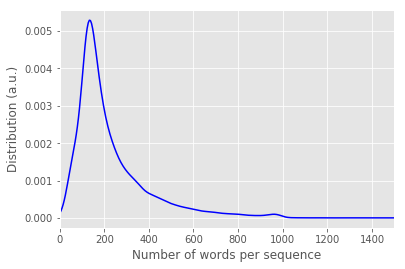

In [11]:
plt.style.use('ggplot')
seq_len_per_rev.plot.density(color='blue')
plt.xlim(0, 1500)
plt.xlabel('Number of words per sequence')
plt.ylabel('Distribution (a.u.)')
plt.show()

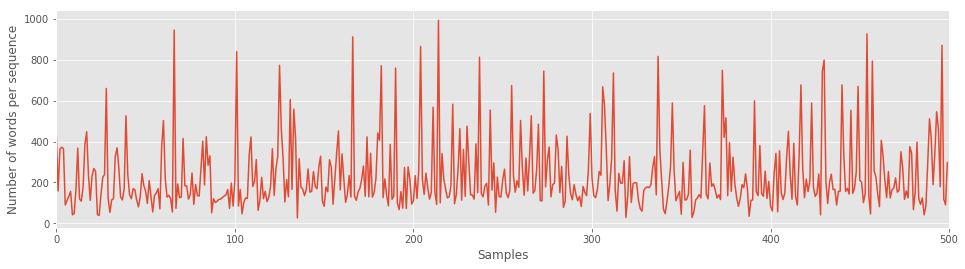

In [12]:
# see the lengths of sequence in a range
plt.figure(figsize=(16,4))
plt.plot(num_of_rev[:500], seq_len_per_rev[:500])
plt.xlim(0, 500)
plt.xlabel('Samples')
plt.ylabel('Number of words per sequence')
plt.show()

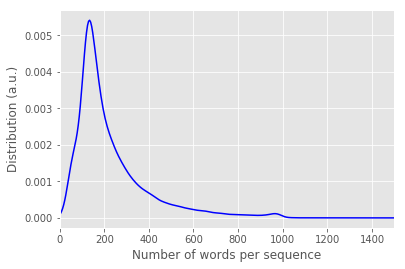

In [13]:
# see the distribution of 'sequence length per review' of unlabeled train data
plt.style.use('ggplot')
ul_train['review'].apply(len).plot.density(color='blue')
plt.xlim(0, 1500)
plt.xlabel('Number of words per sequence')
plt.ylabel('Distribution (a.u.)')
plt.show()

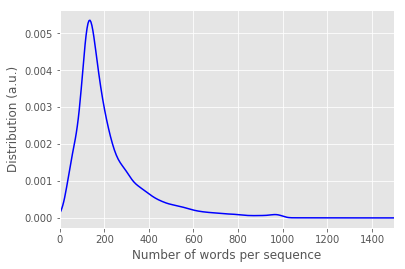

In [14]:
# see the distribution of 'sequence length per review' of test data
plt.style.use('ggplot')
test['review'].apply(len).plot.density(color='blue')
plt.xlim(0, 1500)
plt.xlabel('Number of words per sequence')
plt.ylabel('Distribution (a.u.)')
plt.show()

In [8]:
word_freq = nltk.FreqDist(itertools.chain(
    *pd.concat([train['review'], ul_train['review'], test['review']], ignore_index=True) ))
len(word_freq)

350590

In [9]:
# Tokenize the review sentences as input
vocab_size = 5000
vocab_freq = word_freq.most_common(vocab_size-2)
idx_to_word = ['PAD'] + [w[0] for w in vocab_freq] + ['UNK']
word_to_idx = {w: i for i, w in enumerate(idx_to_word)}

In [10]:
idx_to_word[:10]

['PAD', u'the', u'and', u'a', u'of', u'to', u'is', u'in', u'it', u'this']

In [11]:
idx_to_word[-10:]

[u'milk',
 u'sometime',
 u'homosexuality',
 u'cole',
 u'regarded',
 u'worn',
 u'debate',
 u'testament',
 u'bruno',
 'UNK']

In [12]:
vocab_freq[:5]

[(u'the', 1310970),
 (u'and', 644344),
 (u'a', 643448),
 (u'of', 580666),
 (u'to', 535920)]

In [13]:
vocab_freq[-5:]

[(u'regarded', 304),
 (u'worn', 304),
 (u'debate', 304),
 (u'testament', 304),
 (u'bruno', 303)]

In [14]:
print "Tokenizing the review texts..."
t0 = time()
train['review'] = train['review'].apply(
    lambda x: np.array([word_to_idx[w] if w in idx_to_word else vocab_size-1 for w in x]))
print "Elapsed time %.2f seconds for tokenizing\n" % (time()-t0)

Tokenizing the review texts...
Elapsed time 238.07 seconds for tokenizing



In [16]:
print "Tokenizing the test dataset..."
t0 = time()
test['review'] = test['review'].apply(
    lambda x: np.array([word_to_idx[w] if w in idx_to_word else vocab_size-1 for w in x]))
print "Elapsed time %.2f seconds for tokenizing\n" % (time()-t0)

Tokenizing the test dataset...
Elapsed time 234.03 seconds for tokenizing



In [15]:
# Prepare training
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(
    train['review'], train['sentiment'], test_size=0.15, random_state=0)

seq_len = 500
train_x = sequence.pad_sequences(train_x, maxlen=seq_len, value=0)
val_x = sequence.pad_sequences(val_x, maxlen=seq_len, value=0)

In [16]:
# callback function during training
class CallMetric(kcb.Callback):
    def on_train_begin(self, logs={}):
        self.best_acc = 0.0
        self.accs = []
        self.val_accs = []
        self.losses = []
        self.val_losses = []
    def on_epoch_end(self, batch, logs={}):
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        if logs.get('val_acc') > self.best_acc:
            self.best_acc = logs.get('val_acc')
            print("\nThe BEST val_acc to date.")

In [137]:
def build_nn(embedding_dim):
    inp = Input(shape=(seq_len,), dtype='int32', name='model_input')
    emb = Embedding(vocab_size, embedding_dim, input_length=seq_len, dropout=0.5)(inp)
    x = Flatten()(emb)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    net = Model(inp, x)
    net.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return net

In [138]:
net = build_nn(32)
metricRecords = CallMetric()
checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_nn.h5", monitor='val_acc', 
                                   save_best_only=True, verbose=1)

In [139]:
net.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=3, batch_size=64, 
        callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/3
20800/21250 [============================>.] - ETA: 0s - loss: 0.7071 - acc: 0.5743

In [150]:
net.load_weights(model_path+"imdb_nn.h5")
K.set_value(net.optimizer.lr, 1e-4)
net.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=1, batch_size=64, 
        callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/1
20800/21250 [============================>.] - ETA: 0s - loss: 0.2864 - acc: 0.8802

In [157]:
net = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len, dropout=0.5),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])
net.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])
metricRecords = CallMetric()
checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_nn_2.h5", monitor='val_acc', 
                                   save_best_only=True, verbose=1)

In [167]:
net.load_weights(model_path+"imdb_nn_2.h5")
net.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=1, batch_size=64, 
        callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/1
21056/21250 [============================>.] - ETA: 0s - loss: 0.3398 - acc: 0.8502

In [177]:
net.load_weights(model_path+"imdb_nn_2.h5")
K.set_value(net.optimizer.lr, 1e-4)
net.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=64, 
        callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21184/21250 [============================>.] - ETA: 0s - loss: 0.2921 - acc: 0.8775

### Convolutional net

In [267]:
def build_cnn(embedding_dim):
    inp = Input(shape=(seq_len,), dtype='int32', name='model_input')
    emb = Embedding(vocab_size, embedding_dim, input_length=seq_len, dropout=0.2)(inp)
    x = Dropout(0.2)(emb)
    x = Convolution1D(64, 3, border_mode='same', activation='relu')(x)
    x = Convolution1D(64, 3, border_mode='same', activation='relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D()(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inp, x)
    model.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [268]:
conv = build_cnn(32)
metricRecords = CallMetric()
checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_cnn.h5", monitor='val_acc', 
                                   save_best_only=True, verbose=1)

In [269]:
conv.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=4, batch_size=128, 
          callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/4
21120/21250 [============================>.] - ETA: 0s - loss: 0.6890 - acc: 0.5080

In [271]:
conv.load_weights(model_path+"imdb_cnn.h5")
conv.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=1, batch_size=128, 
          callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/1
21120/21250 [============================>.] - ETA: 0s - loss: 0.2602 - acc: 0.8973

In [272]:
conv.load_weights(model_path+"imdb_cnn.h5")
K.set_value(conv.optimizer.lr, 1e-4)
conv.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
          callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21120/21250 [============================>.] - ETA: 0s - loss: 0.2379 - acc: 0.9089

In [273]:
conv.load_weights(model_path+"imdb_cnn.h5")
K.set_value(conv.optimizer.lr, 1e-4)
conv.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
          callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21120/21250 [============================>.] - ETA: 0s - loss: 0.2376 - acc: 0.9074

In [274]:
conv.load_weights(model_path+"imdb_cnn.h5")
K.set_value(conv.optimizer.lr, 1e-4)
conv.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
          callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21248/21250 [============================>.] - ETA: 0s - loss: 0.2273 - acc: 0.9110

In [254]:
conv1 = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len, dropout=0.2),
    Dropout(0.2),
    Convolution1D(64, 5, border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])
conv1.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])
metricRecords = CallMetric()
checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_cnn.h5", monitor='val_acc', 
                                   save_best_only=True, verbose=1)

In [255]:
conv1.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=4, batch_size=128, 
          callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/4
21120/21250 [============================>.] - ETA: 0s - loss: 0.5981 - acc: 0.6332

In [257]:
conv1.load_weights(model_path+"imdb_cnn.h5")
conv1.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
          callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21120/21250 [============================>.] - ETA: 0s - loss: 0.2649 - acc: 0.8991

In [258]:
conv1.load_weights(model_path+"imdb_cnn.h5")
K.set_value(conv1.optimizer.lr, 1e-4)
conv1.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
          callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21120/21250 [============================>.] - ETA: 0s - loss: 0.2387 - acc: 0.9106

In [259]:
from sklearn.metrics import roc_auc_score
conv1.load_weights(model_path+"imdb_cnn.h5")
pred_val = conv1.predict(val_x, batch_size=128)
np.mean((pred_val.ravel()>=0.5).astype('int8') == val_y), roc_auc_score(val_y, pred_val)

(0.89466666666666672, 0.95740298374075594)

In [261]:
pred_labels_val = conv1.predict_classes(val_x, batch_size=128)

3328/3750 [=========================>....] - ETA: 0s

In [262]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, pred_labels_val)

In [263]:
np.mean(np.array(val_y) == np.ones(3750)), np.mean(np.array(val_y) == np.zeros(3750))

(0.48773333333333335, 0.51226666666666665)

In [264]:
# confusion matrix
cm / np.sum(cm, dtype=np.float32)

array([[ 0.4563,  0.056 ],
       [ 0.0493,  0.4384]])

### Recurrent net

In [18]:
# callback function during training
class CallMetric(kcb.Callback):
    def on_train_begin(self, logs={}):
        self.best_acc = 0.0
        self.accs = []
        self.val_accs = []
        self.losses = []
        self.val_losses = []
    def on_epoch_end(self, batch, logs={}):
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        if logs.get('val_acc') > self.best_acc:
            self.best_acc = logs.get('val_acc')
            print("\nThe BEST val_acc to date.")

In [ ]:
def build_rnn(embedding_dim):
    inp = Input(shape=(1,), dtype='int32', name='model_input')
    emb = Embedding(vocab_size, embedding_dim, input_length=seq_len, dropout=0.2)(inp)
    x = SimpleRNN(64, activation='relu', inner_init='identity', return_sequences=True)(x)
    x = Dropout(0.5)(x)
    x = SimpleRNN(64, activation='relu', inner_init='identity')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    net = Model(inp, x)
    net.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return net

In [22]:
rnn = build_rnn(64)
metricRecords = CallMetric()
checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_rnn.h5", monitor='val_acc', 
                                   save_best_only=True, verbose=1)
rnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 500, 64)       320000      embedding_input_2[0][0]          
____________________________________________________________________________________________________
simplernn_3 (SimpleRNN)          (None, 500, 64)       8256        embedding_2[0][0]                
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 500, 64)       0           simplernn_3[0][0]                
____________________________________________________________________________________________________
simplernn_4 (SimpleRNN)          (None, 64)            8256        dropout_3[0][0]                  
___________________________________________________________________________________________

In [22]:
rnn = Sequential([
    Embedding(vocab_size, 64, input_length=seq_len, mask_zero=True),    
    SimpleRNN(64, activation='relu', inner_init='identity', return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='relu', inner_init='identity'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])
rnn.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
metricRecords = CallMetric()
checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_rnn.h5", monitor='val_acc', 
                                   save_best_only=True, verbose=1)
rnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 500, 64)       320000      embedding_input_2[0][0]          
____________________________________________________________________________________________________
simplernn_3 (SimpleRNN)          (None, 500, 64)       8256        embedding_2[0][0]                
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 500, 64)       0           simplernn_3[0][0]                
____________________________________________________________________________________________________
simplernn_4 (SimpleRNN)          (None, 64)            8256        dropout_3[0][0]                  
___________________________________________________________________________________________

In [23]:
rnn.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=3, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/3
21248/21250 [============================>.] - ETA: 0s - loss: 4.8507 - acc: 0.5139 

In [24]:
rnn.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=3, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/3
21248/21250 [============================>.] - ETA: 0s - loss: 0.3731 - acc: 0.8625 

In [25]:
K.set_value(rnn.optimizer.lr, 1e-4)
rnn.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21248/21250 [============================>.] - ETA: 0s - loss: 0.1883 - acc: 0.9344 

In [27]:
rnn.load_weights(model_path+"imdb_rnn.h5")
K.set_value(rnn.optimizer.lr, 1e-5)
rnn.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21248/21250 [============================>.] - ETA: 0s - loss: 0.1681 - acc: 0.9439 

In [33]:
from sklearn.metrics import roc_auc_score
rnn.load_weights(model_path+"imdb_rnn.h5")
pred_val = rnn.predict(val_x, batch_size=128)
np.mean((pred_val.ravel()>=0.5).astype('int8') == val_y), roc_auc_score(val_y, pred_val)

(0.88426666666666665, 0.94758900574895344)

### Longer memory neurons

In [ ]:
def build_gru(embedding_dim):
    inp = Input(shape=(1,), dtype='int32', name='model_input')
    emb = Embedding(vocab_size, embedding_dim, input_length=seq_len, dropout=0.2)(inp)
    x = GRU(128, consume_less='gpu', dropout_U=0.2, dropout_W=0.2, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = GRU(128, consume_less='gpu', dropout_U=0.2, dropout_W=0.2)(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    net = Model(inp, x)
    net.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return net

In [51]:
gru1 = build_gru(128)
metricRecords = CallMetric()
checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_gru.h5", monitor='val_acc', 
                                   save_best_only=True, verbose=1)
gru1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_6 (Embedding)          (None, 500, 128)      640000      embedding_input_6[0][0]          
____________________________________________________________________________________________________
gru_4 (GRU)                      (None, 512)           984576      embedding_6[0][0]                
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 512)           0           gru_4[0][0]                      
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 1)             513         dropout_7[0][0]                  
Total params: 1625089
_____________________________________________________________________

In [51]:
gru1 = Sequential([
    Embedding(vocab_size, 128, input_length=seq_len, mask_zero=True, W_regularizer=l2(1e-4)),
    GRU(512, consume_less='gpu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])
gru1.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
metricRecords = CallMetric()
checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_gru.h5", monitor='val_acc', save_best_only=True, verbose=1)
gru1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_6 (Embedding)          (None, 500, 128)      640000      embedding_input_6[0][0]          
____________________________________________________________________________________________________
gru_4 (GRU)                      (None, 512)           984576      embedding_6[0][0]                
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 512)           0           gru_4[0][0]                      
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 1)             513         dropout_7[0][0]                  
Total params: 1625089
_____________________________________________________________________

In [52]:
gru1.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=4, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/4
21248/21250 [============================>.] - ETA: 0s - loss: 0.6732 - acc: 0.6750  

In [54]:
gru1.load_weights(model_path+"imdb_gru.h5")
gru1.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21248/21250 [============================>.] - ETA: 0s - loss: 0.3443 - acc: 0.8709  

In [56]:
gru1.load_weights(model_path+"imdb_gru.h5")
gru1.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21248/21250 [============================>.] - ETA: 0s - loss: 0.4019 - acc: 0.8364  

In [61]:
for i in range(8):
    gru1.load_weights(model_path+"imdb_gru.h5")
    gru1.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=1, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/1
21248/21250 [============================>.] - ETA: 0s - loss: 0.2787 - acc: 0.9003  

KeyboardInterrupt: 

In [35]:
gru1.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=4, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/4
21248/21250 [============================>.] - ETA: 0s - loss: 0.6186 - acc: 0.7059  

In [36]:
gru1.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21248/21250 [============================>.] - ETA: 0s - loss: 0.3052 - acc: 0.8919  

In [37]:
K.set_value(gru1.optimizer.lr, 1e-4)
gru1.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21248/21250 [============================>.] - ETA: 0s - loss: 0.1998 - acc: 0.9387  

In [38]:
K.set_value(gru1.optimizer.lr, 2e-5)
gru1.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21248/21250 [============================>.] - ETA: 0s - loss: 0.1788 - acc: 0.9487  

In [41]:
gru1.load_weights(model_path+"imdb_gru.h5")
K.set_value(gru1.optimizer.lr, 1e-5)
gru1.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128, 
         callbacks=[metricRecords, checkpointer])

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21248/21250 [============================>.] - ETA: 0s - loss: 0.1769 - acc: 0.9495  

In [42]:
gru1.load_weights(model_path+"imdb_gru.h5")
gru1.evaluate(val_x, val_y, batch_size=128)

3750/3750 [==============================] - 3s     

[0.29511511096954346, 0.89173333317438763]

In [44]:
from sklearn.metrics import roc_auc_score
gru1.load_weights(model_path+"imdb_gru.h5")
pred_val = gru1.predict(val_x, batch_size=128)
np.mean((pred_val.ravel()>=0.5).astype('int8') == val_y), roc_auc_score(val_y, pred_val)

(0.89173333333333338, 0.95428672589140939)

In [45]:
pred_labels_val = gru1.predict_classes(val_x, batch_size=128)

3750/3750 [==============================] - 3s     

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, pred_labels_val)

In [47]:
np.mean(np.array(val_y) == np.ones(3750)), np.mean(np.array(val_y) == np.zeros(3750))

(0.48773333333333335, 0.51226666666666665)

In [48]:
# confusion matrix
cm / np.sum(cm, dtype=np.float32)

array([[ 0.4589,  0.0533],
       [ 0.0549,  0.4328]])